# Turtle Recall
A facial recognition model for turtles

https://zindi.africa/competitions/turtle-recall-conservation-challenge/data

# Imports

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from PIL import Image

In [2]:
print(f'TensorFlow version is {tf.__version__}')

TensorFlow version is 2.7.0


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


# Dataset

First, we load the data. In addition to the turtles and images from the train.csv file, we also make use of extra_images.csv by concatenation with the train file. This yields substantially more (ca. 10.000) image files to later train the model on.

In [4]:
IMAGE_DIR = './data/images'

In [36]:
train = pd.read_csv("./data/train.csv")
extra_images = pd.read_csv("./data/extra_images.csv")

# Convert image_location strings to lowercase.
for row in [train]:
  row.image_location = row.image_location.apply(lambda x: x.lower())
  assert set(row.image_location.unique()) == set(['left', 'right', 'top'])

df = pd.concat(objs=[train, extra_images])

In [37]:
images_per_turtle = pd.value_counts(df.turtle_id)
print(f'The total number of turtles is {len(df.turtle_id.unique())}.\n'
      'The mean number of training images per turtle is '
      f'{round(np.mean(images_per_turtle), 2)}, '
      f'and the median is {int(np.median(images_per_turtle))}.')

The total number of turtles is 2265.
The mean number of training images per turtle is 5.65, and the median is 3.


As we can see, however, we don't get a lot of images per turtle on average. Actually, some 2000 turtles are represented with less than 10 images in the dataset, which leads to a huge imbalance. Hence, we decide not to make use of any turtle with less than `MIN_NR_IMGS`.

In [38]:
MIN_NR_IMGS = 10

im_per_turtle = images_per_turtle[images_per_turtle >= MIN_NR_IMGS].to_frame()
df = df[df.turtle_id.isin(im_per_turtle.index)].reset_index()

In [39]:
images_per_turtle = pd.value_counts(df.turtle_id)
print(f'The total number of turtles after removal is {len(df.turtle_id.unique())}.\n'
      'The mean number of training images per turtle is now '
      f'{round(np.mean(images_per_turtle), 2)}, '
      f'and the median is {int(np.median(images_per_turtle))}. \n'
      f'The smallest number of images per turtle is '
      f'{min(df.turtle_id.value_counts())}.')

The total number of turtles after removal is 253.
The mean number of training images per turtle is now 19.72, and the median is 14. 
The smallest number of images per turtle is 10.


In [40]:
print(df.shape)
df.head(3)

(4990, 4)


,index,image_id,image_location,turtle_id
0,0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,2,ID_RVATH2HZ,right,t_id_3b65X5Lw


We have now removed a significant portion of the data and are left with about 5000 images, which is still more than double the amount of the initial images in the `train.csv`. There is, however, still a huge imbalance in the dataset and the total number of files is quite small.

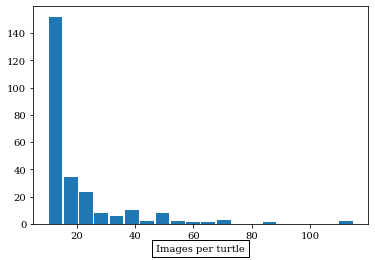

In [66]:
plt.hist(x=images_per_turtle, rwidth=0.9, bins=20)
plt.xlabel('Images per turtle', fontfamily='serif', bbox=dict(facecolor='none', edgecolor='black'))
plt.xticks(fontfamily='serif')
plt.yticks(fontfamily='serif')

plt.savefig('images_per_turtle.png')
plt.show()

# Preprocessing

Create three mappings and get the paths to the training set image files.
1. `labels` : turtle ID --> unique integer labels
1. `label_lookup` : unique integer labels --> turtle ID
1. `image_to_turtle` :  image IDs to turtle IDs (training set only).

In [ ]:
# required by current pipeline
turtle_ids = sorted(np.unique(df.turtle_id)) + ['new_turtle']

image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR) if f.split('.')[0] in df.image_id.values]
image_ids = [os.path.basename(f).split('.')[0] for f in image_files]

image_to_turtle = dict(zip(df.image_id, df.turtle_id))
labels = dict(zip(turtle_ids, np.arange(len(turtle_ids))))

loaded_labels = [labels[image_to_turtle[id]] for id in image_ids]

In [ ]:
# from tutorial.ipynb, but not currently used in pipeline
label_lookup = {v: k for k, v in labels.items()}
num_classes = len(labels)

image_turtle_ids = [image_to_turtle[id] for id in image_ids]

In [ ]:
NUM_CLASSES = len(turtle_ids)
print(f'Number of turtles (classes): {NUM_CLASSES}')

In [ ]:
def crop_and_resize(pil_img, img_size=(224,224)):
  """Crop square from center of image and resize."""

  w, h = pil_img.size
  crop_size = min(w, h)
  crop = pil_img.crop(((w - crop_size) // 2, (h - crop_size) // 2,
                       (w + crop_size) // 2, (h + crop_size) // 2))
  
  return crop.resize(img_size)

tqdm.tqdm._instances.clear()
loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]

In [ ]:
# inspect an image
print(loaded_images[0].size)
print(len(loaded_images))
loaded_images[0]

In [ ]:
ims = tf.stack([tf.convert_to_tensor(np.asarray(im), dtype=tf.float32) for im in loaded_images])
labels = tf.stack(loaded_labels)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((ims, labels))
train_ds = train_ds.map(lambda x,y: (x/255., tf.one_hot(y, NUM_CLASSES)))

print(f'The dataset contains {train_ds.cardinality().numpy()} images.')

### Data augmentation
https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/image_ops.ipynb#scrollTo=tbaIkUCS2eNv

Before applying augmentation to our images and hence increasing the size of our training data, we shuffle the current dataset, take a few images and store them in a test set for eventually evaluating our model. We do this to preserve the real-world data we want our model to work on later. The augmentation is then only used on training and validation data to make sure our model learns with a variety of different images and is robust against noise, different colour and brightness values, etc.

In [ ]:
BUFFER = train_ds.cardinality().numpy()
TEST_SPLIT = 1000

#ds = ds.shuffle(buffer_size=BUFFER, reshuffle_each_iteration=False, )
test_ds, train_ds = train_ds.take(TEST_SPLIT), train_ds.skip(TEST_SPLIT)

print(
    f'Train images: {train_ds.cardinality().numpy()}', 
    f'Test images: {test_ds.cardinality().numpy()}', 
    sep='\n')

We implemented a bunch of augmentation functions to enhance the small dataset. After applying them, we further split off a validation part from the training images which we can use during the training process to assess the progress.

In [ ]:
# from functions.image_augmentation import rotate_images, apply_mean_filter, apply_gaussian_filter, random_hsv, add_noise

# ds_rotated = rotate_images(train_ds)
# ds_gaussian = apply_gaussian_filter(train_ds)
# ds_hsv = random_hsv(train_ds)
# ds_noise = add_noise(train_ds, 0.2)

# train_ds = train_ds.concatenate(ds_rotated).concatenate(ds_gaussian).concatenate(ds_hsv).concatenate(ds_noise)

In [ ]:
BATCH_SIZE = 64
TRAIN_SPLIT = np.round(train_ds.cardinality().numpy() * 0.8)

train_ds, val_ds = train_ds.take(TRAIN_SPLIT), train_ds.skip(TRAIN_SPLIT)

train_ds = train_ds.shuffle(512).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
train_ds = train_ds.cache(filename='cached_train_ds')

val_ds = val_ds.shuffle(256).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache(filename='cached_val_ds')

print(
    f'Training dataset contains {train_ds.cardinality().numpy() * BATCH_SIZE} images after data augmentation.',
    f'Validation dataset contains {val_ds.cardinality().numpy() * BATCH_SIZE} images.',
    sep='\n')

Below is an example of what an image with additive noise looks like. The general image and - most importantly - the shape of the pattern on the turtle's head are preserved, while the original image is altered in such a way that the neural network does not get to see the same image another time.

In [ ]:
# %matplotlib inline

# example = ds.take(1).map(lambda x,y: (x + tf.random.normal(x.shape, mean=0.0, stddev=0.15, dtype=tf.float32), y))
# example = example.map(lambda x,y: (tf.clip_by_value(x, 0.0, 1.0), y))

# for elem in example.take(1):
#     im, label = elem
# plt.imshow(im)
# plt.show()

In [ ]:
#tf.keras.preprocessing.image.random_channel_shift
#tf.keras.preprocessing.image.random_brightness

# Training

In [ ]:
efficientNet = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", trainable=False),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
efficientNet.summary()

In [ ]:
efficientNet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

In [ ]:
efficientNet.fit(train_ds, epochs=10, validation_data=val_ds)

In [ ]:
efficientNet.evaluate(test_ds)